In [481]:
from __future__ import print_function, division
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [312]:
# Defines a ECG dataset
class ECGDataset(Dataset):
    def __init__(self, file):
        self.data = np.loadtxt(f"datasets/{file}.csv", delimiter=',', dtype=np.float64, skiprows=0)
        self.ecgs = torch.Tensor(self.data[:, 1:])
        self.labels = torch.Tensor(self.data[:, [0]])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return((self.ecgs[idx], float(self.labels[idx])))

In [316]:
# Lads data into an ECGDataset object
train = ECGDataset("train")
test = ECGDataset("test/full")

# Loads data into a torch dataloader object
trainset = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=16, shuffle=False)

In [470]:
# Defines network architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(6000, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, 512)
        self.fc6 = nn.Linear(512, 512)
        self.fc7 = nn.Linear(512, 512)
        self.fc8 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        x = F.gelu(self.fc3(x))
        x = F.gelu(self.fc4(x))
        x = F.gelu(self.fc5(x))
        x = F.gelu(self.fc6(x))
        x = F.gelu(self.fc7(x))
        x = torch.sigmoid(self.fc8(x))
        
        return(x)

        
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=6000, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=512, bias=True)
  (fc7): Linear(in_features=512, out_features=512, bias=True)
  (fc8): Linear(in_features=512, out_features=1, bias=True)
)


In [471]:
# Defines the mean-squared-error loss function
def MSE(data, target):
    cost = 0
    for i in range(len(data)):
        cost += (abs(data[i]) - abs(target[i])) ** 2
        
    return cost

In [472]:
# Defines the mean-absolute-error loss function
def MAE(data, target):
    cost = 0
    for i in range(len(data)):
        cost += abs(abs(data[i]) - abs(target[i]))
        
    return cost

In [473]:
# Defines wether or not the program will log the test and training loss
# Note: extremly inefficent and drasticlly increases compute time.
LOG_TEST_LOSS = False
LOG_TRAIN_LOSS = False

if LOG_TRAIN_LOSS or LOG_TEST_LOSS:
    test_loss = []
    train_loss = []
    answers = []

In [474]:
# Defines the number of epochs, or iterations over training data
EPOCHS = 12

# optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [475]:
for epoch in range(EPOCHS):
    for data in trainset:
        net.zero_grad()
        X, y = data
        output = net(X.view(-1, 6000))
        loss = MSE(output, y)
        loss.backward()
        optimizer.step()
        
        if LOG_TRAIN_LOSS:
            with torch.no_grad():
                errors = 0
                for data in trainset:
                    X, y = data
                    output = net(X.view(-1, 6000))
                    errors += MAE(output, y) / len(output)

                train_loss.append(errors / len(trainset))

        if LOG_TEST_LOSS:
            with torch.no_grad():
                errors = 0
                for data in testset:
                    X, y = data
                    output = net(X.view(-1, 6000))
                    errors += MAE(output, y) / len(output)

                test_loss.append(errors / len(testset))

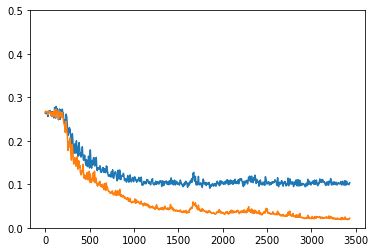

In [476]:
plt.ylim(0, 0.5)
plt.plot(list(test_loss))
plt.plot(list(train_loss))

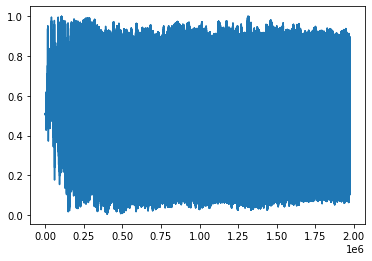

In [477]:
plt.plot(answers)

In [478]:
# Prints out info
error = 0
samples = 0
total = 0
expected_total = 0
mse = 0

with torch.no_grad():
    for data in trainset:
        X, y = data
        output = net(X.view(-1, 6000))
        
        for i in range(len(output)):
            error += abs(abs(float(output[i])) - abs(float(y[i])))
            mse += (abs(float(output[i])) - abs(float(y[i]))) ** 2
            total += float(output[i])
            expected_total += float(y[i])
            samples += 1


print(f"Average error: +-{round(float(error / samples), 10)}")
print(f"Average answer: {total / samples}")
print(f"Expected average: {expected_total / samples}")
print(f"MSE: {mse}")
print(f"avg: {mse / samples}")

Average error: +-0.0223878645
Average answer: 0.5000979085329534
Expected average: 0.49432374558353037
MSE: 4.336871146096558
avg: 0.0009491948229583188


In [479]:
# Prints out info
error = 0
samples = 0
total = 0
expected_total = 0
mse = 0

with torch.no_grad():
    for data in testset:
        X, y = data
        output = net(X.view(-1, 6000))
        
        for i in range(len(output)):
            error += abs(abs(float(output[i])) - abs(float(y[i])))
            mse += (abs(float(output[i])) - abs(float(y[i]))) ** 2
            total += float(output[i])
            expected_total += float(y[i])
            samples += 1


print(f"Average error: +-{round(float(error / samples), 10)}")
print(f"Average answer: {total / samples}")
print(f"Expected average: {expected_total / samples}")
print(f"MSE: {mse}")
print(f"avg: {mse / samples}")

Average error: +-0.1039223772
Average answer: 0.5324429837257966
Expected average: 0.5640043741982916
MSE: 12.326624079342526
avg: 0.021437607094508742


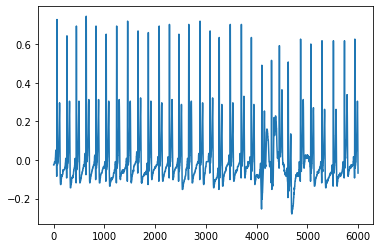

In [480]:
plt.plot(X[0])